In [1]:
#import mplpub
import numpy as np
from ase import Atoms
from ase.io import read
from ase.spacegroup.symmetrize import FixSymmetry
from ase.units import GPa, kB
from calorine.calculators import CPUNEP
from calorine.tools import get_force_constants, relax_structure
from matplotlib import pyplot as plt, colormaps
from pandas import DataFrame, read_json, concat as pd_concat
from phonopy import load, Phonopy, PhonopyQHA
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.units import Avogadro, EvTokJmol, kb_J, THzToEv
from seekpath import get_explicit_k_path
from tqdm import tqdm

R = kb_J * Avogadro
#mplpub.setup(template='acs')

In [2]:
def get_props(
    ph, classical,
    mesh=[40, 40, 40],
    t_min=1, t_max=600, t_step=1,
    freq_min=-5, freq_max=20, freq_pitch=0.05,
):
    # evaluate frequencies on the specified q-point mesh
    ph.run_mesh(mesh)

    # compute thermal properties
    ph.run_thermal_properties(t_min=t_min, t_max=t_max, t_step=t_step, classical=classical)

    # turn results into DataFrame
    tp_dict = ph.get_thermal_properties_dict()
    df_thermo = DataFrame(tp_dict)
    df_thermo['temperature'] = df_thermo.temperatures
    del df_thermo['temperatures']

    # add columns with properties in more convenient units for plotting
    natoms = len(get_structure(ph))
    df_thermo['free_energy_eV'] = df_thermo.free_energy / EvTokJmol / natoms
    df_thermo['entropy_kB'] = df_thermo.entropy / R / natoms
    df_thermo['heat_capacity_kB'] = df_thermo.heat_capacity / R / natoms

    # density of states
    ph.run_total_dos(freq_min=freq_min, freq_max=freq_max, freq_pitch=freq_pitch)
    dos_dict = ph.get_total_dos_dict()
    df_dos = DataFrame(dos_dict)
    df_dos['frequency'] = df_dos.frequency_points
    del df_dos['frequency_points']
    df_dos.total_dos /= natoms

    return df_thermo, df_dos

In [3]:
def get_structure(phonon):
    structure_ph = phonon.primitive
    structure_ase = Atoms(symbols=structure_ph.symbols, cell=structure_ph.cell,
                          scaled_positions=structure_ph.scaled_positions, pbc=True)
    return structure_ase

In [4]:
def labels_to_latex(labels_in):
    labels = [r'$\UG{\Gamma}$' if m == 'GAMMA' else m for m in labels_in]
    labels = [m.replace('SIGMA', r'$\UG{\Sigma}$') if m.startswith('SIGMA') else m for m in labels]
    labels = [m.replace('_', '$_') + '$' if '_' in m else m for m in labels]
    return labels 

In [45]:
colors = {
    'BaZrS3-spg140-I4mcm': 'C0',
    'BaZrS3-spg62-Pnma': 'C1',
    'BaZrS3-spg221-Pm3m': 'C2',
}

labels = {
    'BaZrS3-spg140-I4mcm': 'I4/mcm',
    'BaZrS3-spg62-Pnma': 'Pnma',
    'BaZrS3-spg221-Pm3m': 'Pm-3m',
}

In [46]:
xc = 'HSE'
model_filename = 'nep.txt'
supercell_matrix = [4, 4, 4]

phonons = {}
for sname in labels:
    print(f'sname: {sname}')
    phonons[sname] = {}
    for volsc in tqdm(np.arange(0.92, 1.11, 0.01)):
        volsc = np.around(volsc, decimals=3)
        outfile = f'runs-{xc}/phonon-{sname}-volsc{volsc:.3f}.yaml'
        try:
            ph = load(outfile)
        except:
            structure = read(f'{sname}.xyz')
            cell = structure.cell[:] * volsc ** (1 / 3)
            structure.set_cell(cell, scale_atoms=True)
            calculator = CPUNEP(model_filename)
            structure.calc = calculator
            structure.set_constraint(FixSymmetry(structure))
            relax_structure(structure, constant_volume=True)
            ph = get_force_constants(structure, calculator, supercell_matrix=supercell_matrix)
            ph.save(outfile)

        phonons[sname][volsc] = ph

sname: BaZrS3-spg140-I4mcm


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


sname: BaZrS3-spg62-Pnma


100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


sname: BaZrS3-spg221-Pm3m


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


In [52]:
volsc = 1.0

paths = {}
dfs_phonons = {}
for sname in phonons:
    phonon = phonons[sname][volsc]

    structure = get_structure(phonon)
    structure_tuple = (structure.cell[:], structure.get_scaled_positions(), structure.numbers)
    path = get_explicit_k_path(structure_tuple)
    paths[sname] = path.copy()

    phonon.run_band_structure([path['explicit_kpoints_rel']])
    band = phonon.get_band_structure_dict()

    df = DataFrame(band['frequencies'][0])
    df.index = path['explicit_kpoints_linearcoord']
    dfs_phonons[sname] = df
print(dfs_phonons)

{'BaZrS3-spg140-I4mcm':                 0         1             2         3         4         5   \
0.000000 -0.000002 -0.000002 -1.150211e-07  0.942244  0.942244  1.881735   
0.026673  0.103192  0.113850  2.380599e-01  0.941397  0.956368  1.881535   
0.053346  0.204039  0.226887  4.692571e-01  0.939216  0.996881  1.880804   
0.080019  0.299956  0.338327  6.875789e-01  0.936843  1.058905  1.879166   
0.106693  0.387850  0.447438  8.884739e-01  0.936360  1.136042  1.876031   
...            ...       ...           ...       ...       ...       ...   
3.997064  1.217346  1.261986  1.280141e+00  1.294958  1.567524  1.646871   
4.025640  1.218077  1.222162  1.244152e+00  1.254193  1.567888  1.727262   
4.054217  1.191796  1.202824  1.218505e+00  1.234818  1.567768  1.751491   
4.082794  1.172732  1.175697  1.218724e+00  1.222843  1.567543  1.753856   
4.111371  1.166228  1.166228  1.218790e+00  1.218790  1.567442  1.754649   

                6         7         8         9   ...        20

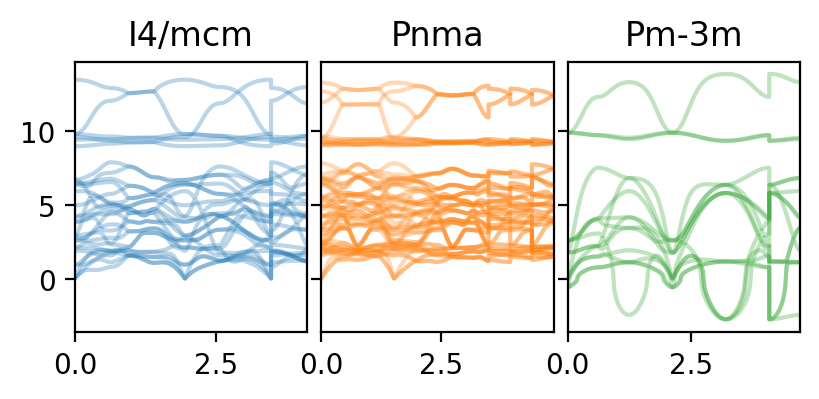

In [50]:
ncols = len(dfs_phonons)

fig, axes = plt.subplots(
    figsize=(4.2, 2.1),
    ncols=len(dfs_phonons),
    sharey=True,
    dpi=200,
)

for icol, (sname, df) in enumerate(dfs_phonons.items()):
    ax = axes[icol]
    path = paths[sname]

    ax.set_title(labels[sname])
    for col in df.columns:
        ax.plot(df.index, df[col], color=colors[sname], alpha=0.3)
    ax.set_xlim(df.index.min(), df.index.max())

    #if icol == 0:
    #    ax.set_ylabel('Frequency (THz)')
    #if icol == ncols - 1:
    #    ax2 = ax.twinx()
    #    ax2.set_ylabel('Frequency (meV)')
    #    ax2.set_ylim(THzToEv * 1e3 * np.array(ax.get_ylim()))

    #qpts_labels = labels_to_latex(path['explicit_kpoints_labels'])
    #df_path = DataFrame(dict(labels=qpts_labels,
    #                         positions=path['explicit_kpoints_linearcoord']))
    #df_path.drop(df_path.index[df_path.labels == ''], axis=0, inplace=True)
    #ax.set_xticks(df_path.positions)
    #ax.set_xticklabels(df_path.labels)
    #for xp in df_path.positions:
    #    ax.axvline(xp, color='0.8')

fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0.06)